# Basic example to use BO optimizer w/ GP

This code will run an offline example as-is without any input arguments. Simply run the file in python.

First, we run [simple BO](#ch1) and then we run [BO with kernel optimization on-the-fly](#ch2).

In order to use it on a specific machine:
1. Change the *importlib.import_module('machine_interfaces.machine_interface_example')* to your machine interface name.
2. Select the name of your .npy file that contains your desired scan params, or change directly the parameters.


In [1]:
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore")

from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP


In [2]:
def saveResults(filename=''):
    """save results if desired. the scan data will be saved 
    to the local directory called 'saved_results' and will 
    have filename formatted as 'scan_YYYY-MM-DD-hhmmss.npy'
    """
    timestr = datetime.now().strftime('%Y-%m-%d-%H%M%S')
    try: os.mkdir('saved_results')
    except: pass
    results = {}
    results['scan_params'] = scan_params
    results['xs'] = opt.X_obs
    results['ys'] = np.array([y[0][0] for y in opt.Y_obs])
    results['time'] = timestr
    np.save('saved_results/scan_'+timestr+filename, results)

### Import machine interface

In [3]:
mi_module = importlib.import_module('machine_interfaces.machine_interface_example')

### Set parameters 
*Here we could either load from a file or choose the parameters directly*

In [4]:
#load the dict that contains the parameters for the scan (control pv list, starting settings, and gp hyperparams)
scan_params_filename = 'my_scan_params.npy'
scan_params = np.load('params/'+scan_params_filename, allow_pickle=True).item()

In [5]:
acquisition_delay = scan_params['acquisition_delay'] # how long to wait between acquisitions
dev_ids = scan_params['dev_ids']
start_point = 0*scan_params['start_point'] #if start_point is set to None, the optimizer will start from the current device settings.

# GP parameters
gp_precisionmat = scan_params['gp_precisionmat']
gp_amp = scan_params['gp_amp'] 
gp_noise_variance =scan_params['gp_noise'] 

*Next we are going to create the machine interface. For this basic example the objective is an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1.*

In [6]:
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 

In [7]:
#check objective noise std
y = [mi.getState()[1][0] for x in range(100)]
np.std(y)

0.00119309304086637

### Create the GP model

In [8]:
ndim = len(dev_ids)
hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude_covar': gp_amp, 'noise_variance': gp_noise_variance} 
gp = OGP(ndim, hyperparams)

In [9]:
np.diag(hyperparams['precisionMatrix']**-0.5)

array([1.41421356, 1.41421356, 1.41421356, 1.41421356])

### Create the BO
*create the bayesian optimizer that will use the gp as the model to optimize the machine.*

In [10]:
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids)
opt.ucb_params = scan_params['ucb_params'] #set the acquisition function parameters
print('ucb_params',opt.ucb_params)

Supposed to be grabbing initial machine state...
x_init [[ 0. -0. -0.  0.]]
y_init [[1.00029291]]
ucb_params [2.0, None]


<a id="ch1"></a>
### Run the optimization
*run the gp search for some number of steps*

In [11]:
Obj_state_s=[]

iteration = 4
current position: [[-3.51985758 18.17193351  0.52392027  1.1443199 ]] current objective value: [[1.75028448e-05]]


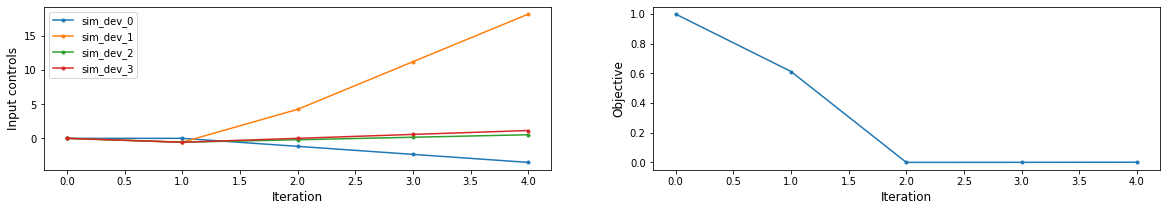

In [12]:
Niter = 5
for i in range(Niter):
    clear_output(wait=True) 
    print ('iteration =', i)
    print ('current position:', mi.x, 'current objective value:', mi.getState()[1])
   
    Obj_state_s.append(mi.getState()[1][0])
    
    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.set_ylabel('Input controls',fontsize=12)
    ax.set_xlabel('Iteration',fontsize=12)
    for x, label in zip(opt.X_obs.T, opt.dev_ids):
        ax.plot(x,'.-',label = label)
    ax.legend()
    ax2.set_ylabel('Objective',fontsize=12)
    ax2.set_xlabel('Iteration',fontsize=12)
    ax2.plot(Obj_state_s,'.-')
    plt.show(); 

    opt.OptIter()
    time.sleep(acquisition_delay)

<a id="ch2"></a>
## BO with kernel optimization on the fly
*Optimize the kernel hyperparameters before acuiring the next point.
       This method optimizes the kernel twice - starting from the initial or last hyperparamters.
       Then compares the log likelihood and re-build the GP model using the most likely hypers.
       **Note**:  sk learn can't deal with matrix, so we can only optimize on lengthscales.*

In [13]:
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point) 
gp = OGP(ndim, hyperparams)

*below we define 'optimize_kernel_on_the_fly' which is the iteration number to start optimize the kernel's hyperparmaters. If None, no optimization of the hypers during BO.*

In [14]:
optimize_kernel_on_the_fly = 2 # or None
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = dev_ids, optimize_kernel_on_the_fly = optimize_kernel_on_the_fly)

Run BO w/ kernel optimization on the fly
Supposed to be grabbing initial machine state...
x_init [[ 0. -0. -0.  0.]]
y_init [[0.99896995]]


In [15]:
Obj_state_s=[]

iteration = 5
current position: [[-4.24264069  4.24264069  2.38390658  3.94068095]] current objective value: [[-0.00079963]]


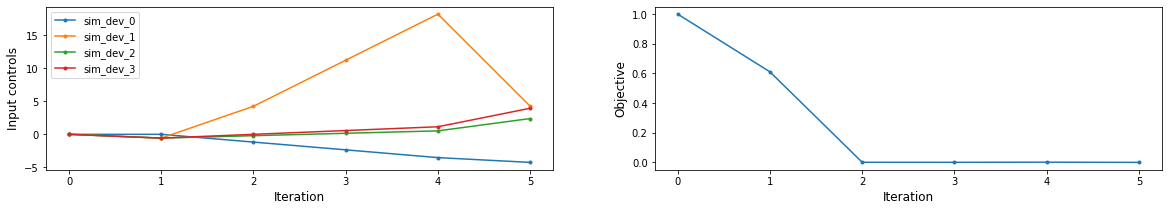

optimize on initial hyperparams
Initial kernel: 1**2 * RBF(length_scale=[1.41, 1.41, 1.41, 1.41])
SK fit time is  0.07235074043273926
Learned kernel: 0.413**2 * RBF(length_scale=[1.39, 1.04, 1.35, 1.35])
Log-marginal-likelihood: -2.837
optimize on last hyperparams seen so far
Initial kernel: 0.455**2 * RBF(length_scale=[1.35, 0.948, 1.66, 1.66])
SK fit time is  0.04931139945983887
Learned kernel: 0.413**2 * RBF(length_scale=[1.35, 0.891, 1.63, 1.63])
Log-marginal-likelihood: -2.837


In [16]:
Niter = 6
for i in range(Niter):
    clear_output(wait=True) 
    print ('iteration =', i)
    print ('current position:', mi.x, 'current objective value:', mi.getState()[1])
   
    Obj_state_s.append(mi.getState()[1][0])
    
    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.set_ylabel('Input controls',fontsize=12)
    ax.set_xlabel('Iteration',fontsize=12)
    for x, label in zip(opt.X_obs.T, opt.dev_ids):
        ax.plot(x,'.-',label = label)
    ax.legend()
    ax2.set_ylabel('Objective',fontsize=12)
    ax2.set_xlabel('Iteration',fontsize=12)
    ax2.plot(Obj_state_s,'.-')
    plt.show(); 
    
    if optimize_kernel_on_the_fly is not None:
        if i > optimize_kernel_on_the_fly:
            opt.optimize_kernel_hyperparameters(noiseQ = False)    

    opt.OptIter()
    time.sleep(acquisition_delay)

Text(0.5, 0, 'iteration')

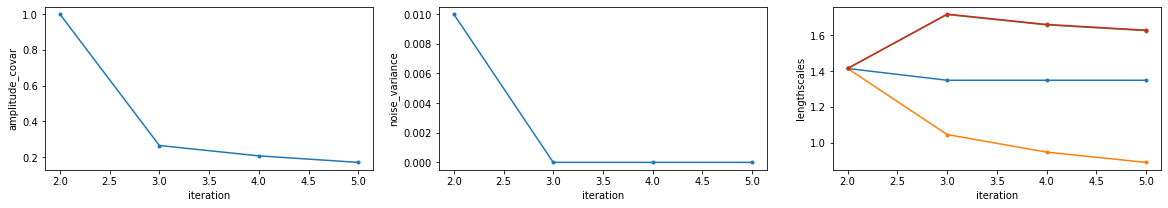

In [17]:
plt.figure(figsize=(20,3))
xs = np.arange(Niter - optimize_kernel_on_the_fly)+optimize_kernel_on_the_fly
plt.subplot(131); plt.plot(xs, opt.hyperparams_opt_all['amplitude_covar'],'.-'); plt.ylabel('amplitude_covar'); plt.xlabel('iteration')
plt.subplot(132); plt.plot(xs, opt.hyperparams_opt_all['noise_variance'],'.-'); plt.ylabel('noise_variance'); plt.xlabel('iteration')
plt.subplot(133);plt.plot(xs, opt.hyperparams_opt_all['precisionMatrix']**-0.5,'.-'); plt.ylabel('lengthscales'); plt.xlabel('iteration')